In [3]:
import json
import logging
import os

import numpy as np
import pandas as pd
from tqdm import tqdm

from graph2gnn import Tiger2GNN


class Cora2GNN(Tiger2GNN):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.num_nodes = 0
        self.labels = None
        self.classes = None

    def compute_vertex_vectors(self):
        vectors = []  # list of (id, vector, label)
        labels = {}  # key: v_id, val: label

        # For each vertex in the query's result set
        vertex_list = json.load(open(f"{self.output_path}/PaperSrc.json"))
        for vert in tqdm(vertex_list, desc="Papers"):

            try:
                assert len(vert["attributes"]["features"]) == 1433
            except AssertionError as e:
                print(len(vert["attributes"]["features"]))
                raise e
            vectors.append(
                [
                    int(vert["attributes"]["id"]),   # ID
                    vert["attributes"]["features"],  # featuers
                    vert["attributes"]["label"],     # label
                ]
            )

            # store the vertex's label by its ID
            labels[int(vert["attributes"]["id"])] = vert["attributes"]["label"]

        # save the list of (id, vector, label) for later use -- it's saved to a file because if your d
        save_arr = np.array(vectors, dtype=object)
        np.save(f"{self.output_path}/PaperSrc", save_arr)

        self.labels = labels
        self.classes = np.unique(list(labels.values()))
        self.num_nodes = len(labels.keys())
        # optimize storage space... don't write everything to a csv
        pd.DataFrame(vectors, columns=["id", "features", "label"]).to_csv(
            f"{self.output_path}/PaperSrc.csv", index=False
        )

    def assemble_data(self, samples_per_class):
        def split_data(papers):
            print("splitting data")
            label_counter = dict.fromkeys(self.classes, 0)
            print("samples_per_class:", samples_per_class)
            train = []
            test = []
            idx = 0

            for i in tqdm(papers, total=self.num_nodes):
                label = i[-1]

                # if this class as all the train data required, move it to test
                if label_counter[label] != samples_per_class:
                    train.append(idx)
                    label_counter[label] += 1

                else:
                    test.append(idx)
                idx += 1

            train_o = sorted(
                np.random.choice(train, int(len(train) * 0.7), replace=False)
            )
            evals = sorted(np.setxor1d(train, train_o))
            np.save("train_idxs", train_o)
            np.save("eval_idxs", evals)
            np.save("test_idxs", test)
            print(f"train:{len(train)} + eval:{len(evals)} ", len(train) + len(evals))
            print("test", len(test))
            print(label_counter)

            self.train_idxs = np.array(train_o)
            self.eval_idxs = np.array(evals)
            self.test_idxs = np.array(test)

        # combine all vectors to one csv/npy file
        self.response_set_keys = ["PaperSrc"]
        for k in tqdm(self.response_set_keys):
            vecs = pd.read_csv(f"{self.output_path}/PaperSrc.csv")
            self.classes = vecs.label.unique()
            split_data(vecs.to_numpy())


with open("tkn.txt") as fin:
    lines = fin.readlines()

tkn = lines[0].replace("\n", "")  # restpp token
host = lines[1]

tg = Cora2GNN(
    host=f"http://{host}",
    graph_name="Cora",
    query="CoraData",
    token=tkn
)

In [4]:
tg.call_singlegraph_query()
tg.compute_vertex_vectors()

Papers: 100%|██████████| 2708/2708 [00:00<00:00, 265570.28it/s]


Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: label, dtype: int64


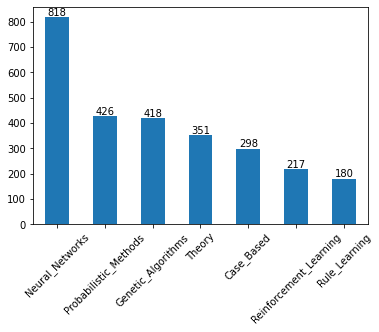

162


  0%|          | 0/1 [00:00<?, ?it/s]

splitting data
samples_per_class: 162


100%|██████████| 1/1 [00:00<00:00, 11.97it/s]

train:1134 + eval:341  1475
test 1574
{'Neural_Networks': 162, 'Rule_Learning': 162, 'Probabilistic_Methods': 162, 'Genetic_Algorithms': 162, 'Theory': 162, 'Reinforcement_Learning': 162, 'Case_Based': 162}


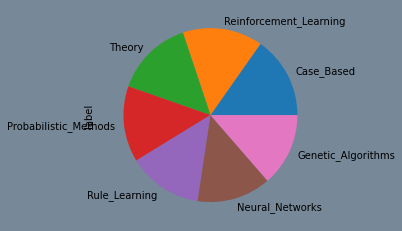

In [5]:
from matplotlib import pyplot as plt
import pandas as pd

stats = pd.read_csv("tgresponse/PaperSrc.csv")[["id", "label"]]
print(stats.label.value_counts())

ax = stats.label.value_counts().plot.bar(rot=45)
ax.bar_label(ax.containers[0])
plt.show()
# 80/20 train test sample split with balanced training examples
samples_per_class = int(stats.label.value_counts().to_numpy()[-1] * 0.9)
print(samples_per_class)
tg.assemble_data(samples_per_class=samples_per_class)

tr_idx = np.load("train_idxs.npy")
fig, ax = plt.subplots(facecolor="lightslategray")
stats.iloc[tr_idx].label.value_counts().plot.pie()
plt.show()


In [6]:
# DATASET
import dgl, torch
from dgl.data import DGLDataset
from sklearn.preprocessing import LabelEncoder


class CoraDataset(DGLDataset):
    def __init__(self, num_nodes, **kwargs):
        self.num_nodes = num_nodes
        self._num_classes = 0
        super().__init__(**kwargs)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.graph

    @property
    def num_classes(self):
        return self._num_classes

    def process(self):
        nodes_data = pd.read_csv("tgresponse/PaperSrc.csv").sort_values(by="id")

        le: LabelEncoder = LabelEncoder()
        labels = le.fit_transform(nodes_data.label.tolist())
        self._num_classes = len(le.classes_)

        nodes_data["features"] = nodes_data["features"].str.replace("[", "")
        nodes_data["features"] = nodes_data["features"].str.replace("]", "")
        vecs = []
        for x in nodes_data.features.str.split(", "):
            a = np.array([np.float(y) for y in x])
            vecs.append(a / np.linalg.norm(a))

        vertex_vectors = torch.from_numpy(np.array(vecs, dtype=np.float32))
        edges = pd.read_csv("tgresponse/edges.csv").sort_values(by="tgt")
        edges_src = torch.from_numpy(edges.tgt.to_numpy())
        edges_tgt = torch.from_numpy(edges.src.to_numpy())

        self.graph = dgl.graph((edges_src, edges_tgt), num_nodes=self.num_nodes)
        self.graph.ndata["feat"] = vertex_vectors
        self.graph.ndata["label"] = torch.from_numpy(
            nodes_data["label"].astype("category").cat.codes.to_numpy().astype(np.long)
        )  # torch.tensor(labels)

        ## split from GCN Paper (https://arxiv.org/pdf/1609.02907.pdf section 5.2)
        # n_nodes = self.num_nodes
        # n_train = 500#int(n_nodes * 0.6)
        # n_val = int(n_nodes * 0.2)
        # train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        # val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        # test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        # train_mask[:n_train] = True
        # val_mask[n_train:n_train + n_val] = True
        # # test_mask[n_train + n_val:] = True
        # test_mask[n_train + n_val:-1000] = True
        # self.graph.ndata['train_mask'] = train_mask
        # self.graph.ndata['val_mask'] = val_mask
        # self.graph.ndata['test_mask'] = test_mask

        # split using balanced classes prepared in tg.assemble data
        train_mask = torch.zeros(self.num_nodes, dtype=torch.bool)
        val_mask = torch.zeros(self.num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(self.num_nodes, dtype=torch.bool)
        train_mask[tg.train_idxs] = True
        val_mask[tg.eval_idxs] = True
        test_mask[tg.test_idxs] = True
        self.graph.ndata["train_mask"] = train_mask
        self.graph.ndata["val_mask"] = val_mask
        self.graph.ndata["test_mask"] = test_mask


/Users/rrossmil/.venv/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
dataset = CoraDataset(num_nodes=tg.num_nodes, name="cora")
g = dataset[0]
print(g.ndata["feat"].shape)
print(g.ndata["label"])
c = np.where(g.ndata["feat"][0] != 0)
print(g.ndata["feat"][0][c])
print(np.sum(g.ndata["feat"][0].numpy() ** 2))
g.ndata["feat"][:5]


/var/folders/rn/tvgft9fx4m154s0lhnmgx5km0000gq/T/ipykernel_56073/2544383809.py:34: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  nodes_data['features'] = nodes_data['features'].str.replace('[','')
/var/folders/rn/tvgft9fx4m154s0lhnmgx5km0000gq/T/ipykernel_56073/2544383809.py:35: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  nodes_data['features'] = nodes_data['features'].str.replace(']','')
/var/folders/rn/tvgft9fx4m154s0lhnmgx5km0000gq/T/ipykernel_56073/2544383809.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted t

torch.Size([2708, 1433])
tensor([1, 1, 4,  ..., 5, 5, 5])
tensor([0.2236, 0.2236, 0.2236, 0.2236, 0.2236, 0.2236, 0.2236, 0.2236, 0.2236,
        0.2236, 0.2236, 0.2236, 0.2236, 0.2236, 0.2236, 0.2236, 0.2236, 0.2236,
        0.2236, 0.2236])
0.99999994


/var/folders/rn/tvgft9fx4m154s0lhnmgx5km0000gq/T/ipykernel_56073/2544383809.py:48: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.graph.ndata['label'] = torch.from_numpy(nodes_data['label'].astype('category').cat.codes.to_numpy().astype(np.long))# torch.tensor(labels)


tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2236, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [8]:
from dgl.nn import GraphConv

import torch
import torch.nn as nn
import torch.nn.functional as F


class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        print(num_classes)
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)
        self.d1 = nn.Dropout(0.5)

    def forward(self, g, in_feat):
        h = F.dropout(in_feat)
        h = self.conv1(g, h)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h


# Create the model with given dimensions
g = dgl.add_self_loop(g)
g = dgl.add_reverse_edges(g)
print(g.ndata["label"].unique(), g.ndata["label"].unique().shape[0])
print(g.ndata["feat"].shape[1])
g


tensor([0, 1, 2, 3, 4, 5, 6]) 7
1433


Graph(num_nodes=2708, num_edges=24424,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

In [9]:
import numpy as np


def train(g, model):
    learning_rate = 1e-2

    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=1e-5
    )
    best_val_acc = 0
    best_test_acc = 0

    history = []
    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    val_mask = g.ndata["val_mask"]
    test_mask = g.ndata["test_mask"]
    for e in range(200):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()

        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        history.append(
            [
                np.float32(train_acc.numpy()),
                np.float32(val_acc.numpy()),
                loss.item(),
                F.cross_entropy(logits[val_mask], labels[val_mask]).item(),
                np.float32(test_acc.numpy()),
            ]
        )

        if e % 5 == 0:
            print(
                f"In epoch {e}, loss: {loss:.3f}, acc: {train_acc:.3f}, val acc: {val_acc:.3f} (best {best_val_acc:.3f}), test acc: {test_acc:.3f} (best {best_test_acc:.3f})"
            )

    return history


model = GCN(g.ndata["feat"].shape[1], 34, g.ndata["label"].unique().shape[0])
history = train(g, model)


7
In epoch 0, loss: 1.946, acc: 0.121, val acc: 0.091 (best 0.091), test acc: 0.159 (best 0.159)
In epoch 5, loss: 1.678, acc: 0.392, val acc: 0.355 (best 0.355), test acc: 0.401 (best 0.401)
In epoch 10, loss: 1.352, acc: 0.695, val acc: 0.610 (best 0.610), test acc: 0.691 (best 0.691)
In epoch 15, loss: 1.035, acc: 0.803, val acc: 0.751 (best 0.751), test acc: 0.801 (best 0.801)
In epoch 20, loss: 0.779, acc: 0.828, val acc: 0.801 (best 0.801), test acc: 0.818 (best 0.818)
In epoch 25, loss: 0.569, acc: 0.875, val acc: 0.848 (best 0.848), test acc: 0.851 (best 0.851)
In epoch 30, loss: 0.444, acc: 0.888, val acc: 0.862 (best 0.865), test acc: 0.855 (best 0.857)
In epoch 35, loss: 0.356, acc: 0.904, val acc: 0.856 (best 0.865), test acc: 0.859 (best 0.857)
In epoch 40, loss: 0.292, acc: 0.907, val acc: 0.853 (best 0.865), test acc: 0.858 (best 0.857)
In epoch 45, loss: 0.263, acc: 0.921, val acc: 0.839 (best 0.883), test acc: 0.861 (best 0.863)
In epoch 50, loss: 0.227, acc: 0.927, va

train_acc    float32
val_acc      float32
loss         float64
val_loss     float64
test_acc     float32
dtype: object


<AxesSubplot:>

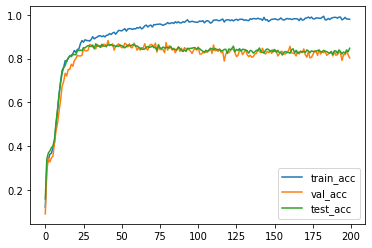

In [10]:
import pandas as pd

df = pd.DataFrame(
    history, columns=["train_acc", "val_acc", "loss", "val_loss", "test_acc"]
)
print(df.dtypes)
df[["train_acc", "val_acc", "test_acc"]].plot()


<AxesSubplot:>

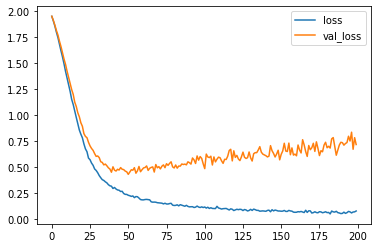

In [11]:
df[["loss", "val_loss"]].plot()


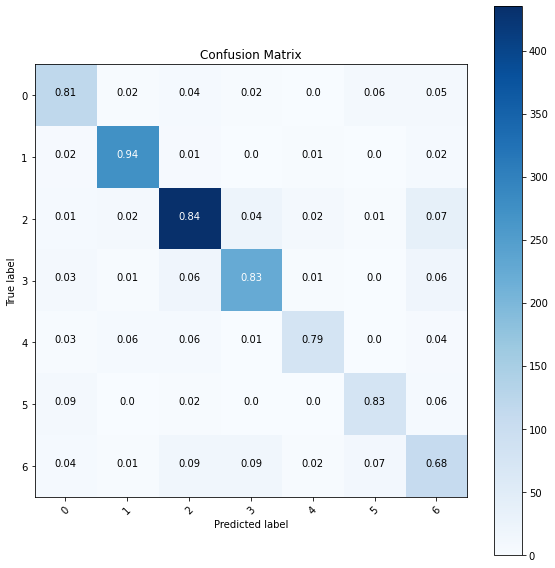

In [12]:
import matplotlib.pyplot as plt
import sklearn.metrics
import itertools

actual = g.ndata["label"][g.ndata["test_mask"]]
predictions = logits = model(g, g.ndata["feat"]).argmax(1)[g.ndata["test_mask"]]


def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
      cm (array, shape = [n, n]): a confusion matrix of integer classes
      class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Compute the labels from the normalized confusion matrix.
    labels = np.around(cm.astype("float") / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    return figure


cm = sklearn.metrics.confusion_matrix(actual, predictions)
figure = plot_confusion_matrix(cm, class_names=g.ndata["label"].unique().numpy())
plt.show()
